In [1]:
import pandas as pd
import numpy as np
import datetime
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

## Options to start the df

In [8]:
def start_from_first_detection(df, voc):
    
    # given the dataframe df and a particular variant of concern voc
    # returns a list of triples (delay, N, K), where
    # delay is the day since first detection of the variant of concern
    # N is the total number of sequences from that day
    # K is the total number of sequences from that variant of concern in that day

    #week = lambda day : day//7 #for coarse graining time
    #df['date']=df['date'].apply(week) #use this if temporal coarse-graining

    #simplify dataframe to simply (date, samples)
    df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')
    
    #day of first detection is set to zero initially, and we create a list of parameters for
    #the hypergeometric distributions associated to each temporal bin
    dayoffirstdetection = -1
    hypergeometricdists = []

    for index, row in df.iterrows(): #iterating over time bins
        K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
        N = len(row['variant']) #total number of sequences in time bin
        # now we drop all data points before the variant is first detected
        # from the day of first detection onward, we create a list with dates and some parameters of the
        # hypergeometric distribution associated to that date

        if (dayoffirstdetection == -1): 
            if K:                      
                dayoffirstdetection = row['date']
                hypergeometricdists.append((0,N,K))
            else:
                df = df.drop([index])
        else: 
            hypergeometricdists.append((row['date']-dayoffirstdetection,N,K))

    x = pd.DataFrame(hypergeometricdists, columns = ['delay', 'N', 'K'])
    return x

def start_from_designation(voc,country):
    
    #Cut Data Frame to start in day of designation
    if voc == 'alpha' or voc == 'beta':
        DESIG = 352
    elif voc == 'gamma':
        DESIG = 376
    elif voc == 'delta':
        DESIG = 459 #VOC:496, VOI:459
    
    df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data
    df = df.groupby('date')['variant'].apply(list).reset_index(name='variant')
    df.index = df['date']
    df = df.drop(df.loc[:DESIG].index)

    new_df = []
    for index, row in df.iterrows(): #iterating over time bins
        K = row['variant'].count(voc) #number of variants of concern sequenced in time bin
        N = len(row['variant']) #total number of sequences in time bin

        new_df.append((row['date']-DESIG,N,K))

    new_df = pd.DataFrame(new_df, columns = ['delay', 'N', 'K'])
    
    return new_df

## Get strategies mean(std) values

In [3]:
#the delays are ALL from start day

def get_stragegies_mean_std(country,NIT,MAX_DAY):
    
    strategy_list = ['fixedDays','BRproportion','casesproportion','homogeneousBR']
    
    if country == 'usa':
        voc_list = ['alpha','beta','gamma','delta']
    else:
        voc_list = ['beta','gamma','delta']
    
    strategy_list_df = []
    voc_list_df = []
    
    means_dict = {}
    
    for voc in voc_list:
        for strategy in strategy_list:
            name_to_save = '{0}'.format(NIT)
            pickle_loc = "/home/renata/Desktop/gabriela_group/final/subsampling_{2}_plot_dict_{0}_{1}_DAYS_{3}_RANDOM_BACK_FORWARD_CORRECTDELAY".format(country,name_to_save,strategy,MAX_DAY)
            
            with open(pickle_loc, 'rb') as handle:
                results_dict = pickle.load(handle)
                        
            if strategy == 'fixedDays':
                for day_value in [7,14,30,60,90,120]:
                    strategy = 'fixedDays-{0}'.format(day_value)
                    list_delays = results_dict[voc][day_value][0]
                    mean = np.mean(list_delays)
                    std = np.std(list_delays)
                
                    if mean < 1:
                        ROUND_MEAN = 2
                    elif mean < 10:
                        ROUND_MEAN = 1
                    else:
                        ROUND_MEAN = None
                    
                    try:
                        mean = round(mean,ROUND_MEAN)
                        std = round(std,ROUND_MEAN)
                    except:
                        mean = 'None'
                        std = 'None'
                    
                    if strategy in means_dict.keys():
                        means_dict[strategy].append([mean,std])      
                    else:
                        means_dict[strategy] = [[mean,std]]

            else:
                list_delays = results_dict[voc]
                mean = np.mean(list_delays)
                std = np.std(list_delays)

                if mean < 1:
                    ROUND_MEAN = 2
                elif mean < 10:
                    ROUND_MEAN = 1
                else:
                    ROUND_MEAN = None

                mean = round(mean,ROUND_MEAN)
                std = round(std,ROUND_MEAN)

                if strategy in means_dict.keys():
                    means_dict[strategy].append([mean,std])
                else:
                    means_dict[strategy] = [[mean,std]] 
            
    means_dict = pd.DataFrame(means_dict)
    means_dict.index = voc_list
    
    return means_dict

## Plot mean in the sequencing real curve

In [5]:
def plot_means_in_real_curve(country,MAX_DAY,FROM_DESIG):
    
    if country == 'usa':
        voc_list = ['alpha','beta','gamma','delta']
        BR_strategy =  'BR ratio (6.7%)'
    else:
        voc_list = ['beta','gamma','delta']
        BR_strategy =  'BR ratio (1.56%)'

    plt.figure()
    plot_dict = {}
    
    color_list = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#f781bf','#a65628']
    color_count = 0
    for voc in voc_list:

        df = pd.read_table("/home/renata/Desktop/gabriela_group/final/dataset_metadata_{0}.csv".format(country),sep=',') #data
        
        if FROM_DESIG:
            x = start_from_designation(voc,country)
            x_label = 'Days since VOC designation'
            save_name = 'desig'
        else:
            x = start_from_first_detection(df, voc)
            x_label = 'Days since VOC first detection'
            save_name = '1detec'

        plot_dict[voc] = x
    
    
    fig, ((ax1, ax2), (ax3,ax4))= plt.subplots(2, 2,figsize = (10,8),constrained_layout=True)
    
    
    name_to_save = '0.5to10_5to100' 
    means_dict_strategies = get_stragegies_mean_std(country,1000,MAX_DAY)
    strategy_list = ['fixedDays-30','fixedDays-60','fixedDays-120','BRproportion','casesproportion','homogeneousBR']
 
    
    if country == 'en':
        ax1.axis('off')
    else:
        voc = 'alpha'
        y = np.max(plot_dict[voc]['K']/plot_dict[voc]['N'])
        ax1.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'],color = 'black')
        ax1.set_title(voc)
        
        means_list = []
        for color_count, strategy_name in enumerate(strategy_list): 
            mean, std = means_dict_strategies.loc[voc,strategy_name]
            if int(mean) in means_list:
                LINESTYLE = 'dashed'
            else:
                LINESTYLE = 'solid'
            means_list.append(int(mean))
            ax1.axvline(mean,-10,1,linestyle=LINESTYLE,color = color_list[color_count],label = strategy_name) 
            ax1.errorbar(mean, y/2, xerr=std,color = color_list[color_count],capsize=5)
        
        
    voc = 'beta'
    y = np.max(plot_dict[voc]['K']/plot_dict[voc]['N'])
    ax2.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'],color = 'black')
    ax2.set_title(voc)
    means_list = []
    for color_count, strategy_name in enumerate(strategy_list): 
        mean, std = means_dict_strategies.loc[voc,strategy_name]
        if int(mean) in means_list:
                LINESTYLE = 'dashed'
        else:
            LINESTYLE = 'solid'
        means_list.append(int(mean))

        ax2.axvline(mean,-10,1,linestyle=LINESTYLE,color = color_list[color_count],label = strategy_name)
        ax2.errorbar(mean, y/2, xerr=std,color = color_list[color_count],capsize=5)

    
    voc = 'gamma'
    y = np.max(plot_dict[voc]['K']/plot_dict[voc]['N'])
    ax3.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'],color = 'black')
    ax3.set_title(voc)
    means_list = []
    for color_count, strategy_name in enumerate(strategy_list): 
        mean, std = means_dict_strategies.loc[voc,strategy_name]
        if int(mean) in means_list:
                LINESTYLE = 'dashed'
        else:
            LINESTYLE = 'solid'
        means_list.append(int(mean))
        ax3.axvline(mean,-10,1,linestyle=LINESTYLE,color = color_list[color_count],label = strategy_name)
        ax3.errorbar(mean, y/2, xerr=std,color = color_list[color_count],capsize=5)

    
    voc = 'delta'
    y = np.max(plot_dict[voc]['K']/plot_dict[voc]['N'])
    ax4.plot(plot_dict[voc]['delay'],plot_dict[voc]['K']/plot_dict[voc]['N'],color = 'black')
    ax4.set_title(voc)
    means_list = []
    for color_count, strategy_name in enumerate(strategy_list): 
        mean, std = means_dict_strategies.loc[voc,strategy_name]
#         if int(mean) in means_list:
#             LINESTYLE = 'dashed'
#         else:
#             LINESTYLE = 'solid'
#         means_list.append(int(mean))
        LINESTYLE = 'solid'
        ax4.axvline(mean,-10,1,linestyle=LINESTYLE,color = color_list[color_count],label = strategy_name)
        ax4.errorbar(mean, y/2, xerr=std,color = color_list[color_count],capsize=5)

    ax4.legend()
    
    
    text1 = fig.text(0.5, 1.04, '{0} - Frequence of each VOC '.format(country), ha='center', fontsize=16)
    text3 = fig.text(0.5, -0.07, x_label , ha='center', fontsize=16)
    text2 = fig.text(-0.04, 0.5, ' VOC/total sequencing', va='center', rotation='vertical', fontsize=16)
    
    plt.savefig("/home/renata/Desktop/gabriela_group/final/subsampling_relative_freq_day_WITH_STRATEGIES{0}_{1}.png".format(country,save_name),dpi = 400,transparent = False,bbox_inches = 'tight',facecolor = 'white')

## problem: this means are calculated with the delays from START DAY, but to plot I need to choose from FIRST DETECTION or VOC DESIGNATION

/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2878: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/renata/anaconda2/envs/python3/lib/python3.6/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 f

<Figure size 432x288 with 0 Axes>

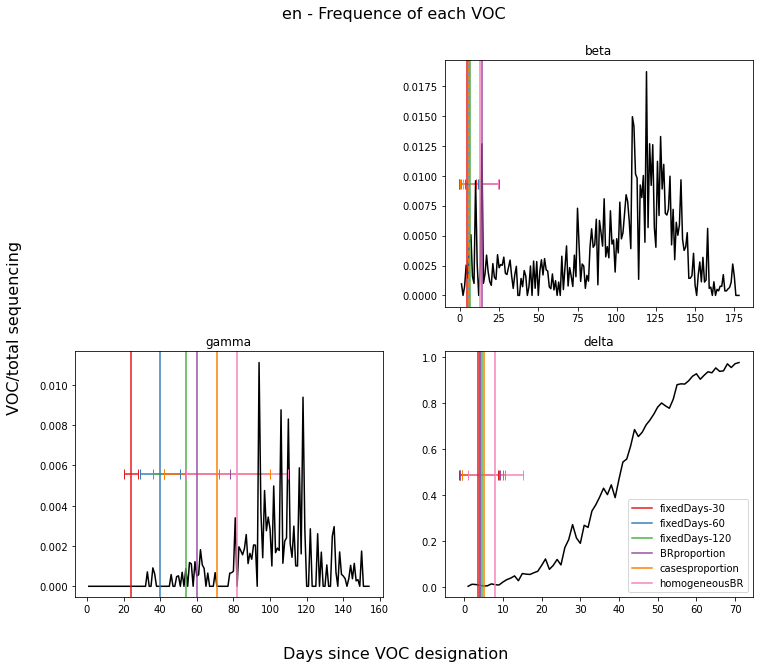

In [10]:
country= 'en'
FROM_DESIG = True
plot_means_in_real_curve(country,31,FROM_DESIG)